In [2]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

s = 1.8
dist = 1

In [3]:
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.ipython_utils import display_vid
from pytorch3d.renderer import FoVPerspectiveCameras

n_frames = 10
angles = torch.linspace(-20, 20, n_frames)
angles = torch.linspace(0, 360, n_frames)

angles = [0, 40, 60, 140, 180, 220, 240, 310, 340]

R, T = turntable_extrinsics(dists=1, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=60)
frame_meshes = mesh.extend(len(frame_cams))

depths = render_depth_map(frame_meshes, frame_cams)

display_vid(pil_frames_to_clip(depths))

In [4]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(
    TexturingPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from text3d2video.noise_initialization import UVNoiseInitializer
from text3d2video.pipelines.texturing_pipeline import TexturingConfig

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = TexturingConfig(
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Stormtrooper"

noise_initializer = UVNoiseInitializer()

generator = torch.Generator(device="cuda")
generator.manual_seed(2)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    conf=gr_config,
    generator=generator,
)

100%|██████████| 15/15 [00:57<00:00,  3.84s/it]


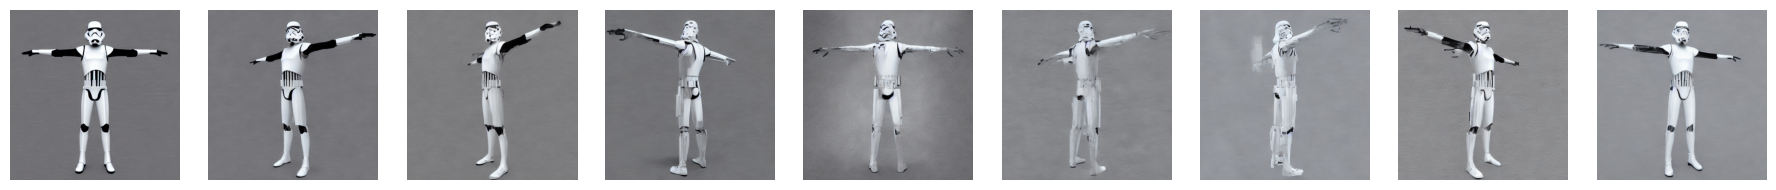

In [90]:
from text3d2video.ipython_utils import display_ims

display_ims(video_frames)

In [6]:
display_vid(pil_frames_to_clip(video_frames))

In [7]:
latents = torch.randn(10, 4, 64, 64)
latents[[0]].shape

torch.Size([1, 4, 64, 64])